# Econ 695 Project 
Due: 12/17/2025. Submit this notebook or other scripts you use to produce the tables and figures along with your report. 

Read "ECON695_project.pdf" for details on each expected output. 

In [33]:
import pandas as pd 
import os  # for setting directory 
# os.chdir() # input your personal directory where the dataset is saved
import statsmodels.formula.api as smf # for OLS regressions
import numpy as np  # to work with arrays (vectors/matrices)
import matplotlib.pyplot as plt # for plots
from scipy import stats
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
import patsy
from numpy.polynomial.polynomial import polyfit, polyval


In [34]:
data = pd.read_csv("projectdata.csv")
print(data.shape)
data.head(2)

(16969, 12)


,y,age,educ,female,exp,yl1,yl2,yl3,yp1,yp2,owage2,owage1
0,2.570021,48,12,0,30,2.620926,2.616735,2.608906,2.784972,2.791555,1.191211,1.122809
1,2.298948,46,12,1,28,2.296236,2.284491,2.275459,2.309241,2.320770,2.397997,2.485690


In [35]:
print(data['female'].value_counts(dropna=False))
print(data['educ'].value_counts(dropna=False))
data.describe()

female
0    10575
1     6394
Name: count, dtype: int64
educ
12    5019
6     4651
9     3859
16    3440
Name: count, dtype: int64


,y,age,educ,female,exp,yl1,yl2,yl3,yp1,yp2,owage2,owage1
count,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000
mean,1.787921,33.558902,10.484118,0.376805,17.074783,1.736934,1.717822,1.696991,1.806854,1.840162,1.692074,1.648420
std,0.645257,5.693736,3.586129,0.484600,6.446165,0.610285,0.600409,0.590419,0.646991,0.650853,0.466264,0.472052
min,0.601944,22.000000,6.000000,0.000000,5.000000,0.603566,0.592804,0.590613,0.637028,0.696327,0.716435,0.718321
25%,1.297586,29.000000,6.000000,0.000000,12.000000,1.276873,1.264874,1.249482,1.315681,1.346496,1.352856,1.299025
50%,1.617799,33.000000,9.000000,0.000000,17.000000,1.576101,1.566374,1.551751,1.635421,1.660561,1.561470,1.550452
75%,2.194695,37.000000,12.000000,1.000000,22.000000,2.120593,2.095272,2.058599,2.216467,2.252076,1.957534,1.889397
max,4.343445,52.000000,16.000000,1.000000,30.000000,4.237082,4.300920,4.315834,4.322492,4.399618,3.804267,3.808492


# Section 1. Overview: Female vs. Male Workers
## Summary Statistics (Table 1)
A suggested format for **Table 1** is to have 4 columns:
- column 1 = characteristics for all workers
- column 2 = characteristics for female workers
- column 3 = characteristics for male workers
- column 4 = test statistic comparing females and males (eg t-test)

See the project.pdf for the list of characteristics. 
Hint: to convert a dataframe to LaTex table, use `table.to_latex(float_format="%.3f")`. You could also copy-paste the estimates into excel and format it manually. 

In [36]:
CSV_PATH = "./projectdata.csv"


# Load
df = pd.read_csv(CSV_PATH)

required = ["age", "educ", "female", "exp", "y", "yp1", "owage2"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

for c in ["age", "educ", "exp", "y", "yp1", "owage2"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["female"] = pd.to_numeric(df["female"], errors="coerce").fillna(0).astype(int)

base = df.dropna(subset=required).copy()

for e in (6, 9, 12, 16):
    base[f"educ_{e}"] = (base["educ"] == e).astype(int)

print("Loaded rows for Part 1:", len(base))


def _summarize(g):
    return pd.Series({
        "Age": g["age"].mean(),
        "Log wage (y)": g["y"].mean(),
        "Mean coworker log wage (owage2)": g["owage2"].mean(),
        "Education (=6)": g["educ_6"].mean(),
        "Education (=9)": g["educ_9"].mean(),
        "Education (=12)": g["educ_12"].mean(),
        "Education (=16)": g["educ_16"].mean(),
    })

all_stats  = _summarize(base)
fem_stats  = _summarize(base.loc[base["female"] == 1])
male_stats = _summarize(base.loc[base["female"] == 0])

rows_for_tests = [
    ("Age", "age"),
    ("Log wage (y)", "y"),
    ("Mean coworker log wage (owage2)", "owage2"),
    ("Education (=6)", "educ_6"),
    ("Education (=9)", "educ_9"),
    ("Education (=12)", "educ_12"),
    ("Education (=16)", "educ_16"),
]

t_rows = []
for label, col in rows_for_tests:
    x = base.loc[base["female"] == 1, col].dropna().values
    yv = base.loc[base["female"] == 0, col].dropna().values
    if len(x) > 1 and len(yv) > 1:
        t_stat, pval = stats.ttest_ind(x, yv, equal_var=False)
    else:
        t_stat, pval = np.nan, np.nan
    t_rows.append((label, t_stat, pval))

t_df = pd.DataFrame(t_rows, columns=["Variable", "t-stat (F−M)", "p-value"]).set_index("Variable")

table1 = pd.concat(
    [all_stats.rename("All workers"),
     fem_stats.rename("Female workers"),
     male_stats.rename("Male workers")],
    axis=1
).join(t_df["t-stat (F−M)"])

TABLE1_OUT = "./table1_overview.csv"
display(table1.round(3))
table1.to_csv(TABLE1_OUT)
print(f"Saved Table 1 → {TABLE1_OUT}")



q1, q2 = np.quantile(base["y"].dropna(), [1/3, 2/3])

def _terc(v):
    if v <= q1: return "T1"
    if v <= q2: return "T2"
    return "T3"

base = base.copy()
base["y_tercile"] = base["y"].apply(_terc)

counts = (
    base.groupby(["female", "y_tercile"], as_index=False)
        .size()
        .rename(columns={"size": "n"})
)

counts["share"] = counts.groupby("female")["n"].transform(lambda s: s / s.sum())

counts["gender"] = counts["female"].map({1: "Female", 0: "Male"})
tercile_table = (
    counts.pivot(index="y_tercile", columns="gender", values="share")
          .reindex(["T1", "T2", "T3"])
          .round(3)
)

display(tercile_table)

Loaded rows for Part 1: 16969


,All workers,Female workers,Male workers,t-stat (F−M)
Age,33.559,33.534,33.574,-0.436
Log wage (y),1.788,1.658,1.866,-20.816
Mean coworker log wage (owage2),1.692,1.638,1.725,-11.676
Education (=6),0.274,0.249,0.289,-5.846
Education (=9),0.227,0.195,0.247,-8.045
Education (=12),0.296,0.329,0.276,7.205
Education (=16),0.203,0.228,0.188,6.232


Saved Table 1 → ./table1_overview.csv


gender,Female,Male
y_tercile,,
T1,0.430,0.275
T2,0.288,0.361
T3,0.282,0.364


## Distribution of Wages (Figure 1)
- Figure 1: histogram of log hourly wages for men and women in one figure. 
- Bonus (Figure 1b): Develop some interesting ways to illustrate the fact that women's wages are lower than men's.

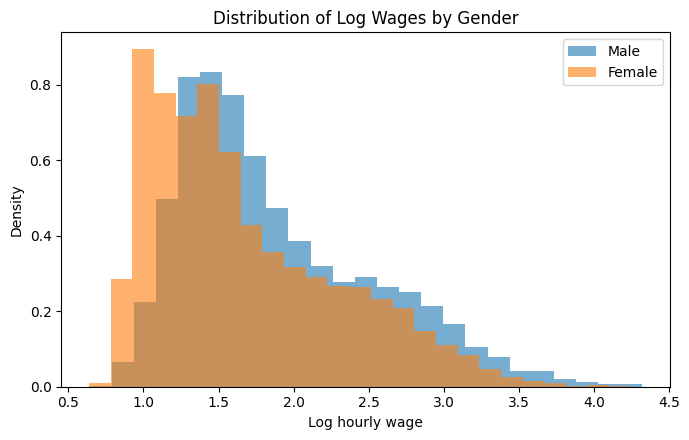

Histogram → ./figure1.png


In [37]:

plt.figure(figsize=(7, 4.5))

male_wages = base.loc[base["female"] == 0, "yp1"].dropna()
female_wages = base.loc[base["female"] == 1, "yp1"].dropna()

plt.hist(male_wages, bins=25, alpha=0.6, label="Male", density=True)
plt.hist(female_wages, bins=25, alpha=0.6, label="Female", density=True)

plt.title("Distribution of Log Wages by Gender")
plt.xlabel("Log hourly wage")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()

FIG1_OUT = "./figure1.png"
plt.savefig(FIG1_OUT, dpi=150)
plt.show()

print(f"Histogram → {FIG1_OUT}")

# Section 2. Gender Wage Gaps
## 2.1 Wage Regressions and Oaxaca Decomposition (Table 2)
In Table 2, you will fit a series of standard wage models. The first set of columns are estimated using the pooled data for women and men. The second set are estimated separately by gender, based on which you can conduct an Oaxaca decomposition. 

In [38]:
# sample code for generating a LaTex Table for regressions 
'''
from statsmodels.iolib.summary2 import summary_col
summary = summary_col(
    results=[model0, model1],
    float_format='%0.3f', stars=False,
    model_names=['(1)', '(2)'],
    info_dict={
        'N': lambda x: f"{int(x.nobs)}", 'Adj R2': lambda x: f"{x.rsquared_adj:.3f}"
    }
)
summary.as_latex()
'''

base = df.copy()
base["exp2"] = base["exp"]**2
base["exp3"] = base["exp"]**3
base["educ_cat"] = pd.Categorical(base["educ"], categories=[6,9,12,16], ordered=True)

# Pooled: y ~ female
mA = smf.ols("y ~ female", data=base).fit(cov_type="HC1")

#  Pooled: y ~ female + C(educ_cat) + exp + exp^2 + exp^3
mB = smf.ols("y ~ female + C(educ_cat) + exp + exp2 + exp3", data=base).fit(cov_type="HC1")

# Split by gender without female dummy
male = base[base["female"]==0].copy()
fem  = base[base["female"]==1].copy()
rhs  = "C(educ_cat) + exp + exp2 + exp3"

mM = smf.ols(f"y ~ {rhs}", data=male).fit(cov_type="HC1")
mF = smf.ols(f"y ~ {rhs}", data=fem).fit(cov_type="HC1")



print("\nTable 2: Pooled Regressions")
print(mA.summary().tables[1])
print(mB.summary().tables[1])

print("\nTable 2: Separate by Gender")
print(mM.summary().tables[1])
print(mF.summary().tables[1])



formula_nofem = "y ~ C(educ_cat) + exp + exp2 + exp3"
yM, XM = patsy.dmatrices(formula_nofem, data=male, return_type="dataframe")
yF, XF = patsy.dmatrices(formula_nofem, data=fem,  return_type="dataframe")
yP, XP = patsy.dmatrices(formula_nofem, data=base, return_type="dataframe")

bM, bF, bRef = sm.OLS(yM, XM).fit().params, sm.OLS(yF, XF).fit().params, sm.OLS(yP, XP).fit().params
Xbar_M, Xbar_F = XM.mean(), XF.mean()

gap_total       = male["y"].mean() - fem["y"].mean()
explained       = float((Xbar_M - Xbar_F) @ bRef)
unexplained_F   = float(Xbar_F @ (bM - bF))
unexplained_M   = float(Xbar_M @ (bM - bF))

if gap_total != 0:
    shares = [
        1.0,
        explained / gap_total,
        unexplained_F / gap_total,
        unexplained_M / gap_total
    ]
else:
    shares = [np.nan, np.nan, np.nan, np.nan]


oaxaca = pd.DataFrame({
    "Value":[gap_total, explained, unexplained_F, unexplained_M],
    "Share of total": shares
}, index=["Total gap (M−F)",
          "Explained (composition)",
          "Unexplained (returns,Fmeans)",
          "Unexplained (returns,Mmeans)"])

print("\n=== Oaxaca–Blinder Decomposition ===")
print(oaxaca.round(4))


Table 2: Pooled Regressions
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8664      0.006    297.381      0.000       1.854       1.879
female        -0.2084      0.010    -20.816      0.000      -0.228      -0.189
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5567      0.055     10.052      0.000       0.448       0.665
C(educ_cat)[T.9]      0.2755      0.008     35.215      0.000       0.260       0.291
C(educ_cat)[T.12]     0.6800      0.009     73.142      0.000       0.662       0.698
C(educ_cat)[T.16]     1.5147      0.011    132.690      0.000       1.492       1.537
female               -0.2706      0.006    -41.968      0.000      -0.283      -0.258
exp                   0.0669      0.011      6.301   

## 2.2 Gender Difference in Experience Profiles
- Figure 2: Plot the relationship between wages and experience for men and women who have one level of education (e.g., education=12), and show the fit of your regression models. 
- Bonus (Figure 2 continued): Consider plotting “Figure 2” for each of the 4 education groups. Within each education group, how much of the gender gap can be explained by differences in experience profile?


Male (education=16)
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.5609      0.172     14.896      0.000       2.224       2.898
exp            -0.0604      0.038     -1.577      0.115      -0.136       0.015
I(exp ** 2)     0.0080      0.003      3.080      0.002       0.003       0.013
I(exp ** 3)    -0.0002    5.4e-05     -3.514      0.000      -0.000   -8.39e-05

Female (education=16)
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.0201      0.174     11.613      0.000       1.679       2.361
exp             0.0152      0.040      0.382      0.702      -0.063       0.093
I(exp ** 2)     0.0026      0.003      0.953      0.341      -0.003       0.008
I(exp ** 3) -7.674e-05   5.85e-05     -1.311      0.190      -0.000     3.8e

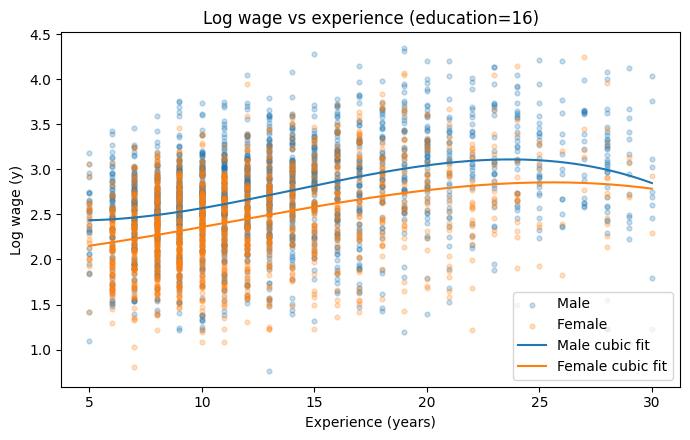

Saved → ./figure2_exp_profiles_edu16.png


In [39]:

g16 = base[(base["educ"] == 16) & (base["exp"].between(5, 30))].copy()
m16 = g16[g16["female"] == 0]
f16 = g16[g16["female"] == 1]

# y ~ exp + exp^2 + exp^3 for each gender
m_model = smf.ols("y ~ exp + I(exp**2) + I(exp**3)", data=m16).fit(cov_type="HC1")
f_model = smf.ols("y ~ exp + I(exp**2) + I(exp**3)", data=f16).fit(cov_type="HC1")

print("\nMale (education=16)")
print(m_model.summary().tables[1])

print("\nFemale (education=16)")
print(f_model.summary().tables[1])

x_grid = np.linspace(5, 30, 200)
m_fit = m_model.predict(pd.DataFrame({"exp": x_grid}))
f_fit = f_model.predict(pd.DataFrame({"exp": x_grid}))

plt.figure(figsize=(7,4.5))
plt.scatter(m16["exp"], m16["y"], s=12, alpha=0.25, label="Male ")
plt.scatter(f16["exp"], f16["y"], s=12, alpha=0.25, label="Female ")
plt.plot(x_grid, m_fit, label="Male cubic fit")
plt.plot(x_grid, f_fit, label="Female cubic fit")
plt.title("Log wage vs experience (education=16)")
plt.xlabel("Experience (years)")
plt.ylabel("Log wage (y)")
plt.legend()
plt.tight_layout()
plt.savefig("./figure2.png", dpi=150)
plt.show()

print("Saved → ./figure2_exp_profiles_edu16.png")

# Section 3. Gender Wage Gaps Conditional on Coworker Wages

**Table 3** will report 5 models. 

The first set of models are estimated in the pooled data for men and women: 
- including only a constant, a female dummy, and owage2
- including a constant, education, a cubic in experience, a female dummy, and owage2
- including a constant, education, a cubic in experience, a female dummy, owage2, and the interaction of owage2 with the female dummy.

Then, fit separate models for men and women that include a constant, education, and a cubic in experience and owage2. Use these models to perform a new decomposition that accounts for the effect of higher-wage coworkers.

In [40]:

base = df.copy()
for c in ["age","educ","female","exp","y","owage2"]:
    base[c] = pd.to_numeric(base[c], errors="coerce")
base = base.dropna(subset=["y","female","educ","exp","owage2"]).copy()
base["exp2"] = base["exp"]**2
base["exp3"] = base["exp"]**3
base["educ_cat"] = pd.Categorical(base["educ"], categories=[6,9,12,16], ordered=True)

# y ~ female + owage2
m1 = smf.ols("y ~ female + owage2", data=base).fit(cov_type="HC1")

# y ~ female + C(educ_cat) + exp + exp2 + exp3 + owage2
m2 = smf.ols("y ~ female + C(educ_cat) + exp + exp2 + exp3 + owage2", data=base).fit(cov_type="HC1")

# y ~ female + C(educ_cat) + exp + exp2 + exp3 + owage2 + female:owage2
m3 = smf.ols("y ~ female + C(educ_cat) + exp + exp2 + exp3 + owage2 + female:owage2", data=base).fit(cov_type="HC1")

print("\nTable 3: Const + Female + owage2")
print(m1.summary().tables[1])

print("\nTable 3: Educ + Exp^3 + owage2")
print(m2.summary().tables[1])

print("\nTable 3: female:owage2")
print(m3.summary().tables[1])

male = base[base["female"] == 0].copy()
fem  = base[base["female"] == 1].copy()

rhs = "C(educ_cat) + exp + exp2 + exp3 + owage2"

m_male = smf.ols(f"y ~ {rhs}", data=male).fit(cov_type="HC1")
m_fem  = smf.ols(f"y ~ {rhs}", data=fem).fit(cov_type="HC1")

print("\nTable 3: Male ")
print(m_male.summary().tables[1])

print("\nTable 3: Female only")
print(m_fem.summary().tables[1])

print("\nCoworker wage coefficient:")
print(f"  Male:   {m_male.params.get('owage2', np.nan):+.4f}")
print(f"  Female: {m_fem.params.get('owage2', np.nan):+.4f}")


Table 3: Const + Female + owage2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1313      0.013     10.388      0.000       0.107       0.156
female        -0.1208      0.007    -17.844      0.000      -0.134      -0.108
owage2         1.0059      0.007    138.861      0.000       0.992       1.020

Table 3: Educ + Exp^3 + owage2
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1988      0.047     -4.213      0.000      -0.291      -0.106
C(educ_cat)[T.9]      0.1528      0.007     23.204      0.000       0.140       0.166
C(educ_cat)[T.12]     0.3771      0.008     44.471      0.000       0.360       0.394
C(educ_cat)[T.16]     1.0113      0.013     80.216      0.000       0.987       1.036
female               -0

In [41]:

# Combine 5 models 
summary = summary_col(
    results=[m1, m2, m3, m_male, m_fem],
    model_names=["(1)", "(2)", "(3)", "(4) Men", "(5) Women"],
    stars=False,
    float_format='%0.3f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}",
        'Adj R2': lambda x: f"{x.rsquared_adj:.3f}"
    }
)

# Display as formatted text (no LaTeX)
print("\n=== Combined Table 3 Summary ===")
print(summary.as_text())



=== Combined Table 3 Summary ===

                    (1)     (2)     (3)   (4) Men (5) Women
-----------------------------------------------------------
Intercept         0.131   -0.199  -0.244  -0.297  -0.284   
                  (0.013) (0.047) (0.048) (0.065) (0.066)  
female            -0.121  -0.189  -0.071                   
                  (0.007) (0.005) (0.019)                  
owage2            1.006   0.634   0.662   0.660   0.598    
                  (0.007) (0.008) (0.009) (0.010) (0.013)  
C(educ_cat)[T.9]          0.153   0.154   0.150   0.165    
                          (0.007) (0.007) (0.008) (0.010)  
C(educ_cat)[T.12]         0.377   0.377   0.394   0.349    
                          (0.008) (0.008) (0.011) (0.012)  
C(educ_cat)[T.16]         1.011   1.013   1.030   0.978    
                          (0.013) (0.013) (0.016) (0.020)  
exp                       0.056   0.055   0.056   0.062    
                          (0.009) (0.009) (0.012) (0.013)  
exp2 

In [42]:

form_ref = "y ~ C(educ_cat) + exp + exp2 + exp3 + owage2"

male = base[base["female"] == 0].copy()
fem  = base[base["female"] == 1].copy()

yM, XM = patsy.dmatrices(form_ref, data=male, return_type="dataframe")
yF, XF = patsy.dmatrices(form_ref, data=fem,  return_type="dataframe")
yP, XP = patsy.dmatrices(form_ref, data=base, return_type="dataframe")

# Coefficients
bM   = sm.OLS(yM, XM).fit().params
bF   = sm.OLS(yF, XF).fit().params
bRef = sm.OLS(yP, XP).fit().params  

Xbar_M = XM.mean()
Xbar_F = XF.mean()

# Totals
gap_total     = male["y"].mean() - fem["y"].mean()
explained     = float((Xbar_M - Xbar_F) @ bRef)     
unexplained_F = float(Xbar_F @ (bM - bF))           
unexplained_M = float(Xbar_M @ (bM - bF))       

# Shares
if gap_total != 0:
    shares = [1.0, explained/gap_total, unexplained_F/gap_total, unexplained_M/gap_total]
else:
    shares = [np.nan]*4

table3_decomp = pd.DataFrame(
    {"Value":[gap_total, explained, unexplained_F, unexplained_M],
     "Share of total": shares},
    index=[
        "Total gap (M-F)",
        "Explained by observables (incl. owage2)",
        "Unexplained (returns, F means)",
        "Unexplained (returns, M means)"
    ]
).round(4)

print("\nTable 3 Decomposition: with coworker wages")
print(table3_decomp)



Table 3 Decomposition: with coworker wages
                                          Value  Share of total
Total gap (M-F)                          0.2084          1.0000
Explained by observables (incl. owage2)  0.0263          0.1262
Unexplained (returns, F means)           0.1866          0.8953
Unexplained (returns, M means)           0.1916          0.9193


# Section 4. Event Study - Wage Changes around Moves

- **Figure 3**: Conduct 9 separate event studies, plotting mean wages in period -3, -2, -1, 0, 1, 2 for people who start in each tercile of `owage1` and go to each tercile of `owage2`.  

- **Table 4**: Model the change in wages from -1 to 0 (y - yl1) as a function of the change in the mean log wage of co-workers (owage2 - owage1).

- **Bonus (Table 4b)**: Apply shrinkage methods to first-differenced models that control for interactions between (owage2 - owage1) and experience dummies. 


## Figure 3
Hint: get the terciles of owage1, owage2 via `qcut`. 
Reshape the data to a panel data at (person, l) level where $l=-3,-2,-1,0,1,2$ -- years relative to the move to the 2nd job. There are multiple ways to reshape the data from wide to long. For example, you can set the index of a dataframe first and then `stack`.   

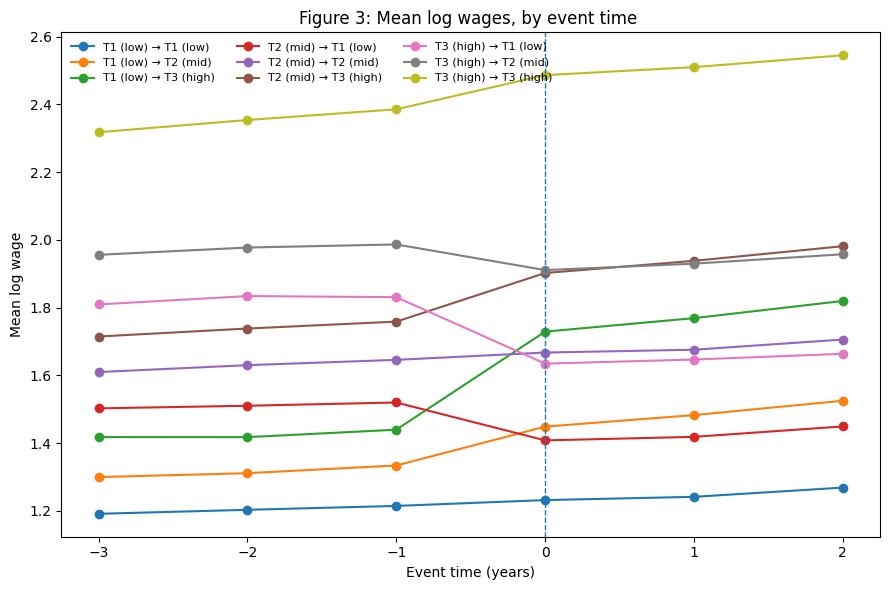

In [43]:

need = ["yl3","yl2","yl1","y","yp1","yp2","owage1","owage2","exp","female","educ"]
panel = df.dropna(subset=need).copy()
panel = panel.reset_index(drop=False).rename(columns={"index":"person_id"})

# Tercile cutpoints from owage1 
q1, q2 = panel["owage1"].quantile([1/3, 2/3]).tolist()
bins = [-np.inf, q1, q2, np.inf]
labels = ["T1 (low)","T2 (mid)","T3 (high)"]

panel["start_terc"] = pd.cut(panel["owage1"], bins=bins, labels=labels, include_lowest=True)
panel["end_terc"]   = pd.cut(panel["owage2"], bins=bins, labels=labels, include_lowest=True)

# event-time panel at l = -3,-2,-1,0,1,2
long_rows = []
for _, r in panel.iterrows():
    pid = r["person_id"]
    
    w_map  = {-3:r["yl3"], -2:r["yl2"], -1:r["yl1"], 0:r["y"], 1:r["yp1"], 2:r["yp2"]}
    # co-worker wages: job 1 for negatives, job 2 for non-negatives
    ow_map = {-3:r["owage1"], -2:r["owage1"], -1:r["owage1"], 0:r["owage2"], 1:r["owage2"], 2:r["owage2"]}
    for l in [-3,-2,-1,0,1,2]:
        long_rows.append({
            "person_id": pid,
            "l": l,
            "wage": w_map[l],
            "owage": ow_map[l],
            "start_terc": r["start_terc"],
            "end_terc": r["end_terc"],
            "female": r["female"],
            "educ": r["educ"],
            "exp0": r["exp"],          
        })
long = pd.DataFrame(long_rows)

# Event-study means 
means = (
    long.groupby(["start_terc","end_terc","l"])["wage"]
        .mean()
        .reset_index()
        .sort_values(["start_terc","end_terc","l"])
)

# 9 trajectories plot
plt.figure(figsize=(9,6))
for s in labels:
    for e in labels:
        seg = means[(means["start_terc"]==s) & (means["end_terc"]==e)]
        if len(seg):
            plt.plot(seg["l"], seg["wage"], marker="o", label=f"{s} → {e}")
plt.axvline(0, linestyle="--", linewidth=1) 
plt.title("Figure 3: Mean log wages, by event time ")
plt.xlabel("Event time (years)")
plt.ylabel("Mean log wage")
plt.legend(ncol=3, fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig("./figure3.png", dpi=150)
plt.show()


## Table 4:

In [44]:

import numpy as np, pandas as pd
import statsmodels.formula.api as smf

fd = df.dropna(subset=["y","yl1","owage2","owage1","exp","female","educ"]).copy()
fd["dy"] = fd["y"] - fd["yl1"]
fd["d_ow"] = fd["owage2"] - fd["owage1"]
fd["exp_m1"] = fd["exp"] - 1
fd["exp_m1_sq"] = fd["exp_m1"]**2
fd["female"] = pd.to_numeric(fd["female"], errors="coerce").fillna(0).astype(int)
fd["educ_cat"] = pd.Categorical(fd["educ"], categories=[6,9,12,16], ordered=True)

# dy ~ female + d_ow
fd_a = smf.ols("dy ~ female + d_ow", data=fd).fit(cov_type="HC1")

# quadratic in exp as of period -1
fd_b = smf.ols("dy ~ female + d_ow + exp_m1 + exp_m1_sq", data=fd).fit(cov_type="HC1")

# interaction female*d_ow
fd_c = smf.ols("dy ~ female + d_ow + exp_m1 + exp_m1_sq + female:d_ow", data=fd).fit(cov_type="HC1")

print("\nTable 4 (Pooled) — (a) dy ~ female + d_ow ")
print(fd_a.summary().tables[1])
print("\n Table 4 (Pooled) — (b) + exp_{-1}^2 ")
print(fd_b.summary().tables[1])
print("\nTable 4 (Pooled) — (c) + female*d_ow ")
print(fd_c.summary().tables[1])

# dy ~ d_ow + exp_{-1} + exp_{-1}^2
fd_male  = fd[fd["female"]==0].copy()
fd_fem   = fd[fd["female"]==1].copy()

fd_m = smf.ols("dy ~ d_ow + exp_m1 + exp_m1_sq", data=fd_male).fit(cov_type="HC1")
fd_f = smf.ols("dy ~ d_ow + exp_m1 + exp_m1_sq", data=fd_fem).fit(cov_type="HC1")

print("\n Table 4 (Men only)")
print(fd_m.summary().tables[1])
print("\nTable 4 (Women only)")
print(fd_f.summary().tables[1])

# Quick comparison: fraction of OLS coworker effect (Table 3) that survives in first-diff
try:
    frac_m = fd_m.params["d_ow"] / m_male.params["owage2"]
    frac_f = fd_f.params["d_ow"] / m_fem.params["owage2"]
    print("\nFraction of OLS coworker effect seen in first-differences:")
    print(f"  Men:   {frac_m:.3f}  (= FD coef / OLS coef on owage2)")
    print(f"  Women: {frac_f:.3f}")
except Exception as e:
    print("\n(Info) To compute fractions, run Section 3B first so m_male/m_fem exist.")


Table 4 (Pooled) — (a) dy ~ female + d_ow 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0453      0.003     16.754      0.000       0.040       0.051
female        -0.0189      0.004     -4.700      0.000      -0.027      -0.011
d_ow           0.2937      0.008     37.175      0.000       0.278       0.309

 Table 4 (Pooled) — (b) + exp_{-1}^2 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1533      0.014     11.331      0.000       0.127       0.180
female        -0.0221      0.004     -5.536      0.000      -0.030      -0.014
d_ow           0.2902      0.008     37.033      0.000       0.275       0.306
exp_m1        -0.0095      0.002     -5.596      0.000      -0.013      -0.006
exp_m1_sq      0.0002   4.87e-05      3.112     

## Bonus: Shrinkage


d_ow                        0.244
d_ow:C(exp_bin)[T.6-10]     0.061
d_ow:C(exp_bin)[T.11-15]    0.070
d_ow:C(exp_bin)[T.16-20]    0.127
d_ow:C(exp_bin)[T.≥21]      0.121
female:d_ow                -0.109
dtype: float64


/Users/ankitmodi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ankitmodi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ankitmodi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ankitmodi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ankitmodi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ankitmodi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ 

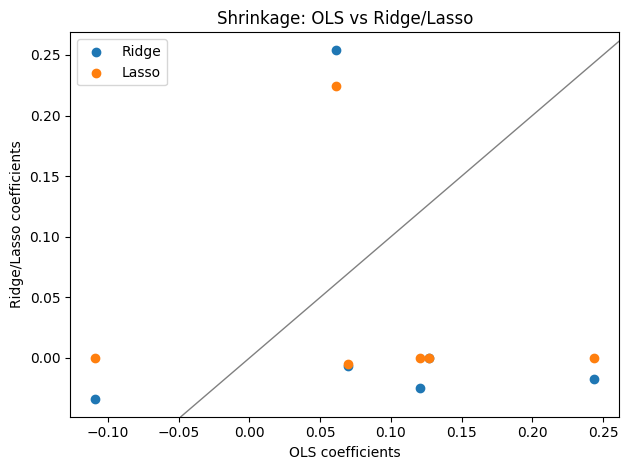

In [45]:
# For Ridge/Lasso: 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

# Suppose you have defined a dataframe/matrix X with regressors, and y = change in log wage. Try the following: 
'''
fd_Ridge =RidgeCV(fit_intercept=True,cv=5).fit(X, y) 
# extract coefficients: 
[fd_Ridge.intercept_.item()] + fd_Ridge.coef_.tolist()
# For Lasso: 
fd_Lasso =LassoCV(cv=5).fit(X, y)
[fd_Lasso.intercept_.item()] + fd_Lasso.coef_.tolist()
'''

fd["exp_bin"] = pd.cut(fd["exp_m1"], [-np.inf,5,10,15,20,np.inf],
                       labels=["≤5","6-10","11-15","16-20","≥21"])

# OLS with interactions
f_ols = "dy ~ female + d_ow + exp_m1 + exp_m1_sq + C(exp_bin) + d_ow:C(exp_bin) + female:d_ow"
m_ols = smf.ols(f_ols, data=fd).fit(cov_type="HC1")
print(m_ols.params.filter(like="d_ow").round(3))

# Ridge/Lasso setup
X = pd.get_dummies(fd[["female","d_ow","exp_bin","exp_m1","exp_m1_sq"]],
                   drop_first=True)
for c in [col for col in X if "exp_bin" in col]:
    X[f"d_ow:{c}"] = X["d_ow"] * X[c]
X["female:d_ow"] = X["female"] * X["d_ow"]
y = fd["dy"]

ridge = RidgeCV(cv=5).fit(X, y)
lasso = LassoCV(cv=5).fit(X, y)

# Shrinkage plot
ols_coefs = m_ols.params.filter(like="d_ow").dropna().values
ridge_coefs = ridge.coef_[:len(ols_coefs)]
lasso_coefs = lasso.coef_[:len(ols_coefs)]

plt.scatter(ols_coefs, ridge_coefs, label="Ridge")
plt.scatter(ols_coefs, lasso_coefs, label="Lasso")
plt.axline((0,0), slope=1, color="gray", lw=1)
plt.title("Shrinkage: OLS vs Ridge/Lasso")
plt.xlabel("OLS coefficients")
plt.ylabel("Ridge/Lasso coefficients")
plt.legend()
plt.tight_layout()
plt.show()
